## Things to adjust 

1. Scaling
2. tau diff
3. tau lim
4. Adjust link angle limits


tau_sum
foot_velocity
walking speed

In [1]:
%reset
from pyomo.environ import*
from pyomo.opt import SolverFactory
from pyomo.opt import SolverStatus, TerminationCondition
import sympy as sym
import numpy as np
from IPython.display import display
from sympy import pprint

import dill
dill.load_session('Biped_absAngles_RelVel.db')


def hide_sloution(hiddenLines):
    from IPython.core.display import display, HTML
    toggle_code_str = '''
    <form action="javascript:code_toggle()"><input type="submit" id="toggleButton" value="Show Solution: {0}"></form>
    '''.format(hiddenLines)

    toggle_code_prepare_str = '''
        <script>
        function code_toggle() {
            if ($('div.cell.code_cell.rendered.selected div.input').css('display')!='none'){
                $('div.cell.code_cell.rendered.selected div.input').hide();
            } else {
                $('div.cell.code_cell.rendered.selected div.input').show();
            }
        }
        </script>

    '''

    display(HTML(toggle_code_prepare_str))
    display(HTML(toggle_code_str))
    
hide_sloution('Import Files')

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [2]:
# Set parameters
h_min = 0.5
h_max = 1.0

tau_diff_lim = 7
# using the 24V values 
rated_torque = 15.0
speed_rated_torque = 23.0 
peak_torque = 38.0
no_load_speed = 27.9 

max_foot_height = 0.05

tests = {0:'High_Drop', 1:'Low_Drop', 2:'Periodic_Walk',\
         3:'Start_Periodic_Walk', 4:'Stop_Periodic_Walk'}

test = tests[0]
mu_value = 1

# NOTE: there is a link between the knee angle and unstretched leg length - kinematics
# knee = 120deg --> r = 0.45

knee_angle_max = 120 # deg
unstretched_leg_length = 0.38
speed_factor = 0.4 # Remy paper 0.4, 0.5 and 1
V_avg = speed_factor*sqrt(unstretched_leg_length*9.81)


if test == 'High_Drop' or test == 'Low_Drop':
    N = 50
    TT = 0.1
elif test == 'Start_Periodic_Walk':
    N = 50
    TT = 1.0
    #TT = xfinal/V_avg
elif test == 'Periodic_Walk':
    #     x_final = stride_length
    N = 100
    TT = 0.5 #0.5 # 0.2 for optimal
elif test =='Stop_Periodic_Walk':
    N = 50
    TT = 0.3
else:
    pass


In [3]:
hide_sloution('Symbolic Imports')
func_map = {'sin':sin, 'cos':cos} 

sym_list = [g] + [BLD] + [foot_angle] + [foot_length] +\
           [cg] + [lx_boom] + [ly_boom] + [N_GR] +\
           [y_boomOffset] + [y_bodyOffset] + [x_footOffset] +\
           [COMR[link,leg] for leg in legs for link in links]+\
           [masses[base] for base in bases] +\
           [masses[link,leg] for leg in legs for link in links] +\
           [lengths[base] for base in bases] +\
           [lengths[link,leg] for leg in legs for link in links] +\
           [inertias['body']] + [inertias['boom','X']] + [inertias['boom','Y']] + [inertias['motors']] +\
           [inertias[link,leg] for leg in legs for link in links] +\
           [x_body]+[y_body]+[th_body]+[th[link,leg] for leg in legs for link in links] +\
           [dx_body]+[dy_body]+[dth_body]+[dth[link,leg] for leg in legs for link in links] +\
           [ddx_body]+[ddy_body]+[ddth_body]+ [ddth[link,leg] for leg in legs for link in links] +\
           [tau['left',leg] for leg in legs] + [tau['right',leg] for leg in legs] +\
           [lamda['x',leg] for leg in legs] + [lamda['y',leg] for leg in legs] +\
           [GRF['x',leg] for leg in legs] + [GRF['y',leg] for leg in legs]

lamb_EOMs = {}

DOFs = ['x_body'] + ['y_body'] + ['theta_body']

for leg in legs:
    for link in links:
        DOFs = DOFs + ['theta_{0}'.format(link+leg)]

for dof_i,dof in enumerate(DOFs):
    lamb_EOMs.update({dof: sym.lambdify(sym_list,EOMs[dof_i],modules = [func_map])})


In [4]:
hide_sloution('Parameters')
# PARAMETERS:

COMR_ = {'ULA': 41.14/174.5,
         'LLA': 132.2/300,
         'URA': 41.14/174.5,
         'LRA': 190.4/295.5,
         'ULB': 41.14/174.5,
         'LLB': 132.2/300,
         'URB': 41.14/174.5,         
         'LRB': 190.4/295.5}

masses_ = {'body': 5756.78/1000,
           'boom': 2470.66/1000,
           'ULA': 153.81/1000,
           'LLA': 346.45/1000,
           'URA': 153.81/1000,
           'LRA': 499.95/1000,
           'ULB': 153.81/1000,
           'LLB': 346.45/1000,
           'URB': 153.81/1000,
           'LRB': 499.95/1000}

lengths_ = {'body': 253/1000,
            'boom': None,
            'ULA': 174.5/1000,
            'LLA': 300.0/1000,
            'URA': 174.5/1000,
            'LRA': 295.5/1000,
            'ULB': 174.5/1000,
            'LLB': 300.0/1000,
            'URB': 174.5/1000,
            'LRB': 295.5/1000}

inertias_ = {'body': 32124078.52*1e-9, # body rotate about its center 
             'boom_X': 1947254622.19*1e-9,
             'boom_Y': 1947254622.19*1e-9,
             'motors': 181877.41*1e-9,
             'ULA': 600933.68*1e-9, # rotates as pendulumn
             'LLA': 4659658.63*1e-9,
             'URA': 600933.68*1e-9,
             'LRA': 7369968.50*1e-9,
             'ULB': 600933.68*1e-9, # rotates as pendulumn 
             'LLB': 4659658.63*1e-9,
             'URB': 600933.68*1e-9,
             'LRB': 7369968.50*1e-9}

all_links = []
all_links_inertia = []
leg_links = []
[leg_links.append(link+leg) for leg in legs for link in links]
[all_links.append(base) for base in bases]
[all_links.append(link+leg) for leg in legs for link in links]
all_links_inertia.append('body')
all_links_inertia.append('boom_X')
all_links_inertia.append('boom_Y')
all_links_inertia.append('motors')
[all_links_inertia.append(link+leg) for leg in legs for link in links]


total_mass = 0.0
for mass in masses_: # must equal ~ 9.1 - 9.5kg
    if mass == 'boom':
        total_mass += masses_[mass]*0.5
    else:
        total_mass += masses_[mass]
print("Mass must equal 9.1 - 9.5kg, current mass value = ",total_mass)


WDOFs = ['X','Y'] 
signs = ['-ve','+ve'] 
#ground_constraints = ['contact','friction','slip_+ve','slip_-ve','no_slip'] # Group all constraints occuring at the ground
ground_constraints = ['contact','no_slip'] 

sides = ['left','right']
coordinates = {'X':0 , 'Y':1}
motor_w_angle = {'left': 'UL' ,'right': 'UR'}

def get_var_list_zeros(m,n):
    var_list = [m.g] + [m.BLD] + [m.foot_angle] + [m.foot_length] +\
               [m.cg] + [m.lx_boom] + [m.ly_boom] + [m.N_GR] +\
               [m.y_boomOffset] + [m.y_bodyOffset] + [m.x_footOffset] +\
               [m.COMR[link+leg] for leg in legs for link in links]+\
               [m.masses[base] for base in bases] +\
               [m.masses[link+leg] for leg in legs for link in links] +\
               [m.lengths[base] for base in bases] +\
               [m.lengths[link+leg] for leg in legs for link in links] +\
               [m.inertias['body']] + [m.inertias['boom_X']] + [m.inertias['boom_Y']] + [m.inertias['motors']]+\
               [m.inertias[link+leg] for leg in legs for link in links] +\
               [m.q[n,dof] for dof in DOFs] +\
               [m.dq[n,dof] for dof in DOFs] +\
               [m.ddq[n,dof] for dof in DOFs] +\
               [0 for leg in legs] + [0 for leg in legs] +\
               [0 for leg in legs] + [0 for leg in legs] +\
               [0 for leg in legs] + [0 for leg in legs]
    return var_list

def get_var_list_values(m,n):
    
    BW = 1
    check = 0
    tau_value = {}
    connection_force_value = {}
    GRF_X_value = {}
    GRF_Y_value = {}
    
    for leg in legs:
        
        [tau_value.update({(side,leg): check*BW*(m.tau_torque[n,side,leg])}) for side in sides]
        [connection_force_value.update({(wdof,leg):BW*(m.connect_force[n,wdof,leg])}) for wdof in WDOFs]
        GRF_X_value.update({(leg):BW*(m.GRF_x[n,'+ve',leg]-m.GRF_x[n,'-ve',leg])})
        GRF_Y_value.update({(leg):BW*(m.GRF_y[n,leg])})

    var_list = [m.g] + [m.BLD] + [m.foot_angle] + [m.foot_length] +\
               [m.cg] + [m.lx_boom] + [m.ly_boom] + [m.N_GR] +\
               [m.y_boomOffset] + [m.y_bodyOffset] + [m.x_footOffset] +\
               [m.COMR[link+leg] for leg in legs for link in links]+\
               [m.masses[base] for base in bases] +\
               [m.masses[link+leg] for leg in legs for link in links] +\
               [m.lengths[base] for base in bases] +\
               [m.lengths[link+leg] for leg in legs for link in links] +\
               [m.inertias['body']] + [m.inertias['boom_X']] + [m.inertias['boom_Y']] + [m.inertias['motors']]+\
               [m.inertias[link+leg] for leg in legs for link in links] +\
               [m.q[n,dof] for dof in DOFs] +\
               [m.dq[n,dof] for dof in DOFs] +\
               [m.ddq[n,dof] for dof in DOFs] +\
               [tau_value['left',leg] for leg in legs] + [tau_value['right',leg] for leg in legs] +\
               [connection_force_value['X',leg] for leg in legs] + [connection_force_value['Y',leg] for leg in legs] +\
               [GRF_X_value[leg] for leg in legs] + [GRF_Y_value[leg] for leg in legs]
    return var_list



Mass must equal 9.1 - 9.5kg, current mass value =  9.30015


--------------
Stall torque =  85.40816326530614
Max speed =  27.9
--------------


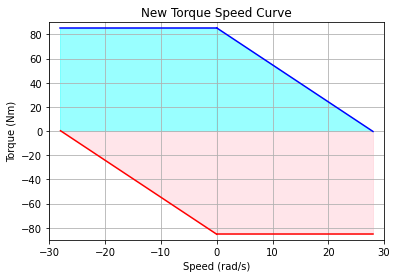

In [5]:
hide_sloution('Torque Speed Curve Display')

'''Plot Torque Speed Curve'''
import matplotlib.pyplot as plt
x_p = np.linspace(0, int(no_load_speed+1), num=int(no_load_speed+1))
x_n = np.linspace(-int(no_load_speed+1), 0, num=int(no_load_speed+1))

# using the 24V values 
rated_torque = 15.0
speed_rated_torque = 23.0 
peak_torque = 38.0
no_load_speed = 27.9 

m_grad = (rated_torque-0.0)/(speed_rated_torque-no_load_speed)

stall_torque = 0.0 - m_grad*no_load_speed

y_p = m_grad*x_p+stall_torque
y_n = m_grad*x_n-stall_torque

stall_torque_p = []
stall_torque_n = []
rated_torque_p = []
rated_torque_n = []

for ii in range(len(x_p)):
    stall_torque_p.append(stall_torque)
    stall_torque_n.append(-stall_torque)
    rated_torque_p.append(peak_torque)
    rated_torque_n.append(-peak_torque)

plt.grid()
plt.plot(x_p, y_p,'b')
plt.plot(x_n, stall_torque_p,'b')

plt.fill_between(x_p, y_p, alpha=0.4, color = 'cyan')
plt.fill_between(x_n, stall_torque_p, alpha=0.4,color = 'cyan')

plt.plot(x_n, y_n,'r')
plt.plot(x_p, stall_torque_n,'r')

plt.fill_between(x_n, y_n, alpha=0.4,color = 'pink')
plt.fill_between(x_p, stall_torque_n, alpha=0.4,color = 'pink')

plt.axis((-30,30,-90,90))
plt.title('New Torque Speed Curve')
plt.xlabel('Speed (rad/s)')
plt.ylabel('Torque (Nm)')
print('--------------')

print('Stall torque = ',stall_torque)
print('Max speed = ',no_load_speed)

print('--------------')

In [6]:
hide_sloution('Integration')
m = ConcreteModel('Biped_th0_Imotors')

#SETS-------------------------
m.N = RangeSet(N)
m.ground_constraints = Set(initialize = ground_constraints)
m.legs = Set(initialize = legs)
m.links = Set(initialize = links)
m.bases = Set(initialize = bases)
m.all_links = Set(initialize = all_links)
m.leg_links = Set(initialize = leg_links)
m.all_links_inertia = Set(initialize = all_links_inertia)
m.DOFs = Set(initialize = DOFs)
m.WDOFs = Set(initialize = WDOFs)
m.signs = Set(initialize = signs)
m.sides = Set(initialize = sides)

#FixedParams--------------------------
m.g = Param(initialize = 9.81)
m.BLD = Param(initialize = 60/1000)
m.foot_angle = Param(initialize = 135*(np.pi/180))
m.foot_length = Param(initialize = 42.5/1000)
m.cg = Param(initialize = 1.149)
m.lx_boom = Param(initialize = 2.575)
m.ly_boom = Param(initialize = 2.493)
m.y_boomOffset = Param(initialize = 0.101)
m.y_bodyOffset = Param(initialize = 8.36/1000)
m.x_footOffset = Param(initialize = 1.63/1000)
m.N_GR = Param(initialize = 9)


m.COMR = Param(m.leg_links, initialize = COMR_)
m.masses = Param(m.all_links, initialize = masses_)
m.lengths = Param(m.all_links, initialize = lengths_)
m.inertias = Param(m.all_links_inertia, initialize = inertias_)


#VARIABLES----------------------
#gen coordinates
m.q = Var(m.N,m.DOFs)
m.dq = Var(m.N,m.DOFs)
m.ddq = Var(m.N,m.DOFs)

''' CONSTRAINTS  - Integration'''
# variable timestep
hm = TT/N # master timestep
m.h = Var(m.N, bounds = (h_min,h_max)) #m.h = Var(m.N, bounds = (0.5,1.5))

def BwEuler_p(m,n,dof):
    if n > 1:
        return m.q[n,dof] == m.q[n-1,dof] + hm*m.h[n]*m.dq[n,dof]
    else:
        return Constraint.Skip
m.integrate_p = Constraint(m.N, m.DOFs, rule = BwEuler_p)

def BwEuler_v(m,n,dof):
    if n > 1:
        return m.dq[n,dof] == m.dq[n-1,dof] + hm*m.h[n]*m.ddq[n,dof]
    else:
        return Constraint.Skip 
m.integrate_v = Constraint(m.N, m.DOFs, rule = BwEuler_v)

    we will be changing that default to 'Reals' in the future.  If you really
    intend the domain of this Param (lengths) to be 'Any', you can suppress
    this warning by explicitly specifying 'within=Any' to the Param
    constructor.  (deprecated in 5.6.9, will be removed in 6.0) (called from
    /home/uct/anaconda3/envs/test-ipopt/lib/python3.9/site-
    packages/pyomo/core/base/param.py:77)


In [7]:
hide_sloution('Connection Constraint')
''' CONSTRAINTS  - CONNECTION POINT'''
m.connect_position = Var(m.N, m.WDOFs, m.sides, m.legs) # connection point
m.connect_force = Var(m.N, m.WDOFs, m.legs,bounds = (-10*total_mass*9.81,10*total_mass*9.81)) # connection force

# Lamdify
lamb_connect_position = {} # (WDOFs,sides,leg)
[lamb_connect_position.update({(wdof,side,leg): sym.lambdify(sym_list,connect_position[side,leg][coordinates[wdof]],modules = [func_map])}) for leg in legs for side in sides for wdof in WDOFs]

# Equate the connection equations from the previous script to the model m
def def_connect_position_equation(m,n,wdof,side,leg):
    var_list = get_var_list_zeros(m,n)    
    return m.connect_position[n,wdof,side,leg] == lamb_connect_position[wdof,side,leg](*var_list)
m.connect_position_equation = Constraint(m.N, m.WDOFs, m.sides, m.legs, rule = def_connect_position_equation)

# Ensure that there is no distance between the X (and Y) of link connection points
def def_connect_position(m,n,wdof,leg):
    return  m.connect_position[n,wdof,'right',leg] - m.connect_position[n,wdof,'left',leg] == 0.0
m.connect_position_constraint = Constraint(m.N, m.WDOFs, m.legs, rule= def_connect_position)

In [8]:
hide_sloution('Ground Contact Constraints')
#Variable of foot position
m.foot_position = Var(m.N, m.WDOFs, m.legs)
for n in range(1,N+1):
    for leg in legs:
        m.foot_position[n,'Y',leg].setlb(0.0)

#Get the foot position in WDOF
lamb_foot_position = {}
[lamb_foot_position.update({(wdof,leg): sym.lambdify(sym_list,foot_position['right',leg][coordinates[wdof]],modules = [func_map])}) for leg in legs for wdof in WDOFs]

def def_foot_position(m,n,wdof,leg):
    var_list = get_var_list_zeros(m,n)
    return m.foot_position[n,wdof,leg] == lamb_foot_position[wdof,leg](*var_list)
m.def_foot_position = Constraint(m.N, m.WDOFs, m.legs, rule = def_foot_position)

m.mu = Param(initialize = mu_value,within=Any)

# Variables
m.foot_velocity = Var(m.N, m.WDOFs, m.signs, m.legs, bounds = (0.0,None)) # the sign will account for -ve velocities
m.foot_velocity_x = Var(m.N, m.legs) 
m.friction_cone = Var(m.N, m.legs, bounds = (0.0,None)) 
m.GRF_y = Var(m.N, m.legs, bounds = (0.0,10*total_mass*m.g.value)) # ground reaction forces
m.GRF_x = Var(m.N, m.signs, m.legs, bounds = (0.0,10*total_mass*m.g.value)) # ground reaction forces

m.ground_penalty = Var(m.N, m.ground_constraints, m.legs, bounds = (0.0,10.0)) # penalty

lamb_foot_velocity_x = {}

# Get the foot position in WDOF
[lamb_foot_velocity_x.update({(leg): sym.lambdify(sym_list,(foot_position['right',leg].jacobian(q)*dq)[0].simplify(),modules = [func_map])}) for leg in legs]

# CONSTRAINTS
def def_foot_velocity(m,n,wdof,leg):
    if wdof == 'X':
        var_list = get_var_list_zeros(m,n)
        return m.foot_velocity[n,'X','+ve',leg]-m.foot_velocity[n,'X','-ve',leg] == lamb_foot_velocity_x[leg](*var_list)
    else: return Constraint.Skip
m.foot_velocity_constraint = Constraint(m.N, m.WDOFs, m.legs, rule = def_foot_velocity)

def def_foot_velocity_x(m,n,wdof,leg):
    if wdof == 'X':
        var_list = get_var_list_zeros(m,n)
        return m.foot_velocity_x[n,leg] == lamb_foot_velocity_x[leg](*var_list)
    else: return Constraint.Skip
m.def_foot_velocity_x_constraint = Constraint(m.N, m.WDOFs, m.legs, rule = def_foot_velocity_x)

def def_friction_cone(m,n,leg):
    return (m.GRF_x[n,'+ve',leg] + m.GRF_x[n,'-ve',leg]) <= m.mu*m.GRF_y[n,leg]
m.friction_cone_constraint = Constraint(m.N, m.legs, rule = def_friction_cone)

# constraints: complementarity

# contact
def def_ground_contact(m,n,leg):
    if n < N:
        return m.foot_position[n+1,'Y',leg]*m.GRF_y[n,leg] <= m.ground_penalty[n,'contact',leg]
    else:
        return Constraint.Skip
m.ground_contact_constraint = Constraint(m.N, m.legs, rule = def_ground_contact)

# friction
# def def_ground_friction(m,n,leg):
#     return (m.foot_velocity[n,'X','+ve',leg]+m.foot_velocity[n,'X','-ve',leg])*m.friction_cone[n,leg] <= m.ground_penalty[n,'friction',leg]
# m.ground_friction_constraint = Constraint(m.N, m.legs, rule = def_ground_friction)

# # (μ * GRFy - ΣGRFx) * dx ≈ 0
# # Only allows the foot to have horizontal velocity when it goes out of the friction cone
# def friction_complementarity(m,n,f):
#     α = m.friction_cone[n,f]
#     β = sum(m.foot_dx[n,:,f,:])
#     return α * β <= m.friction_penalty[n,f]
# model.friction_complementarity = Constraint(model.fe, model.feet, rule=friction_complementarity)



# # slipping
# def def_ground_slip_positive(m,n,leg):
#     return m.foot_velocity[n,'X','+ve',leg]*m.GRF_x[n,'+ve',leg] <= m.ground_penalty[n,'slip_+ve',leg]
# m.ground_slip_positive_constraint = Constraint(m.N, m.legs, rule = def_ground_slip_positive)

# def def_ground_slip_negative(m,n,leg):
#     return m.foot_velocity[n,'X','-ve',leg]*m.GRF_x[n,'-ve',leg] <= m.ground_penalty[n,'slip_-ve',leg]
# m.ground_slip_negative_constraint = Constraint(m.N, m.legs, rule = def_ground_slip_negative)

# def def_no_slip(m,n,leg):
#     # set GRF to zero if dx!=0 and vice versa
#     return m.foot_velocity_x[n,leg]*m.GRF_y[n,leg] == 0.0
# m.def_no_slip_constraint = Constraint(m.N, m.legs, rule = def_no_slip) 

def def_no_slip(m,n,leg):
    # set GRF to zero if dx!=0 and vice versa
    return (m.foot_velocity[n,'X','+ve',leg]-m.foot_velocity[n,'X','-ve',leg])*m.GRF_y[n,leg] <= m.ground_penalty[n,'no_slip',leg]
m.def_no_slip_constraint = Constraint(m.N, m.legs, rule = def_no_slip) 



# # GRFx * dx ≈ 0
# # ensures the friction force acts in the opposite direction to the foot velocity
# def slip_complementarity(m,n,f,s):
#     α = sum(m.GRFx[n,:,f,s])
#     β = sum(m.foot_dx[n,:,f,s])
#     return α * β <= m.slip_penalty[n,f,s]
# model.slip_complementarity = Constraint(model.fe, model.feet, model.signs, rule=slip_complementarity)

#bound contact forces at last node
for leg in legs:
    m.GRF_y[N,leg].fix(0.0)
    for sgn in signs:
        m.GRF_x[N,sgn,leg].fix(0.0)


In [9]:
hide_sloution('Torque Speed Curve Constraint')
'''Torque Speed - Speed Torque Curve'''

m.tau_torque = Var(m.N, m.sides, m.legs, bounds = (-peak_torque,peak_torque))
# m.tau_velocity = Var(m.N, m.sides, m.legs, bounds = (-no_load_speed,no_load_speed))

# lamb_tau_velocity = {}

# def def_relative_angular_velocity_motors (m,n,side,leg):
#     if side == 'left':
#         return m.tau_velocity[n,side,leg] ==  m.dq[n,'theta_UL'+leg] - m.dq[n,'theta_body']
#     elif side == 'right':
#         return m.tau_velocity[n,side,leg] ==  m.dq[n,'theta_UR'+leg] - m.dq[n,'theta_body']
#     else:
#         return Constraint.Skip
# m.def_relative_angular_velocity_motors_constraint = Constraint(m.N, m.sides, m.legs, rule = def_relative_angular_velocity_motors)

# # assume straight line
# def def_TW_right(m,n,side,leg):
#     return m.tau_torque[n,side,leg] <= m.tau_velocity[n,side,leg]*m_grad + stall_torque
# m.TW_right_constraint = Constraint(m.N, m.sides, m.legs, rule = def_TW_right)

# def def_TW_left(m,n,side,leg):
#     return m.tau_torque[n,side,leg] >= m.tau_velocity[n,side,leg]*m_grad - stall_torque
# m.TW_left_constraint = Constraint(m.N, m.sides, m.legs, rule = def_TW_left)

In [10]:
# hide_sloution('Limit Torque Difference')
# def def_max_change_torque(m,n,side,leg):
#     if n<(N-1):
#         return abs(m.tau_torque[n+1,side,leg] - m.tau_torque[n,side,leg]) <= tau_diff_lim
#     else:
#         return abs(m.tau_torque[n,side,leg] - m.tau_torque[n-1,side,leg]) <= tau_diff_lim
# m.max_change_torque = Constraint(m.N, m.sides, m.legs, rule = def_max_change_torque)

In [11]:
hide_sloution('Knee Angle Limit')
# Set the angles for the knees - only use this when actuated 
# This ensures links does not cross
m.knee_angle = Var(m.N, m.sides, m.legs, bounds = (0.0,knee_angle_max*(np.pi)/180))
m.relative_position = Var(m.N, m.DOFs)

def def_relative_angular_position (m,n,dof):
    if 'UL' in dof:
        return m.relative_position[n,dof] ==  m.q[n,'theta_UL'+leg] - m.dq[n,'theta_body']
    elif 'LL' in dof:
        return m.relative_position[n,dof] ==  m.q[n,'theta_LL'+leg] + np.pi - m.q[n,'theta_UL'+leg]
    elif 'UR' in dof:
        return m.relative_position[n,dof] ==  m.q[n,'theta_UR'+leg] - m.dq[n,'theta_body']
    elif 'LR' in dof:
        return m.relative_position[n,dof] ==  m.q[n,'theta_LR'+leg] + np.pi - m.q[n,'theta_UR'+leg]
    else:
        return Constraint.Skip
m.def_relative_angular_position_constraint = Constraint(m.N, m.DOFs, rule = def_relative_angular_position)



# def def_knee_angle(m,n,side,leg):
#     if side == 'left':
#         return m.knee_angle[n,side,leg] == np.pi - m.q[n,'theta_LL'+leg] + m.q[n,'theta_UL'+leg]
#     else:
#         return m.knee_angle[n,side,leg] == np.pi - m.q[n,'theta_UR'+leg] + m.q[n,'theta_LR'+leg]   
# m.knee_angle_constraint = Constraint(m.N, m.sides, m.legs, rule = def_knee_angle)

In [12]:
hide_sloution('Periodic Constraints')
# Get the foot position in WDOF
if test == "Periodic_Walk" or test == "Periodic_Hop":
    
    lamb_body_position_x = sym.lambdify(sym_list,(r_bases['body'])[0].simplify(),modules = [func_map])
    m.body_position = Var(m.N, m.WDOFs) # the sign will account for -ve velocities

    # CONSTRAINTS
    def def_body_position(m,n,wdof):
        var_list = get_var_list_zeros(m,n)
        if wdof == 'X':
            return m.body_position[n,'X'] == lamb_body_position_x(*var_list)
        else: return Constraint.Skip
    m.body_position_constraint = Constraint(m.N, m.WDOFs, rule = def_body_position)
    
    
    if test == "Periodic_Walk":
        
        # Average velocities
        def def_body_position_average(m,wdof):
            if wdof == 'X':
                return (m.body_position[N,'X'] - m.body_position[1,'X'])/(sum(hm*m.h[n] for n in range(1,N+1))) == V_avg
            else: return Constraint.Skip
        m.def_body_position_average_constraint = Constraint(m.WDOFs, rule = def_body_position_average)
        
        # Equate states
        def def_equate_position_states(m,n,dof_i):
            if dof_i == 'y_body' or dof_i == 'theta_body':
                return m.q[1,dof_i] == m.q[N,dof_i]
            
            elif dof_i == 'theta_ULA':
                return m.q[1,'theta_ULA'] == m.q[N,'theta_ULB']
            elif dof_i == 'theta_ULB':
                return m.q[1,'theta_ULB'] == m.q[N,'theta_ULA']
            
            elif dof_i == 'theta_URA':
                return m.q[1,'theta_URA'] == m.q[N,'theta_URB']
            elif dof_i == 'theta_URB':
                return m.q[1,'theta_URB'] == m.q[N,'theta_URA']
            
            elif dof_i == 'theta_LLA':
                return m.q[1,'theta_LLA'] == m.q[N,'theta_LLB']
            elif dof_i == 'theta_LLB':
                return m.q[1,'theta_LLB'] == m.q[N,'theta_LLA']
            
            elif dof_i == 'theta_LRA':
                return m.q[1,'theta_LRA'] == m.q[N,'theta_LRB']
            else: 
                 return Constraint.Skip
        m.def_equate_position_states_constraint = Constraint(m.N, m.DOFs, rule = def_equate_position_states) 

        
        def def_equate_velocity_states(m,n,dof_i):
            if dof_i == 'y_body' or dof_i == 'theta_body':
                return m.dq[1,dof_i] == m.dq[N,dof_i]
            elif dof_i == 'theta_ULA':
                return m.dq[1,'theta_ULA'] == m.dq[N,'theta_ULB']
            elif dof_i == 'theta_ULB':
                return m.dq[1,'theta_ULB'] == m.dq[N,'theta_ULA']
            
            elif dof_i == 'theta_URA':
                return m.dq[1,'theta_URA'] == m.dq[N,'theta_URB']
            elif dof_i == 'theta_URB':
                return m.dq[1,'theta_URB'] == m.dq[N,'theta_URA']
            
            elif dof_i == 'theta_LLA':
                return m.dq[1,'theta_LLA'] == m.dq[N,'theta_LLB']
            elif dof_i == 'theta_LLB':
                return m.dq[1,'theta_LLB'] == m.dq[N,'theta_LLA']
            
            elif dof_i == 'theta_LRA':
                return m.dq[1,'theta_LRA'] == m.dq[N,'theta_LRB']

            else: 
                 return Constraint.Skip
        m.def_equate_velocity_states_constraint = Constraint(m.N, m.DOFs, rule = def_equate_velocity_states) 
          
    else: 
        
        def def_equate_position_states(m,n,dof_i):
            return m.q[1,dof_i] == m.q[N,dof_i]
        m.def_equate_position_states_constraint = Constraint(m.N, m.DOFs,rule = def_equate_position_states)
        
        def def_equate_vel_states(m,n,dof_i):
            return m.dq[1,dof_i] == m.dq[N,dof_i]
        m.def_equate_vel_states_constraint = Constraint(m.N, m.DOFs,rule = def_equate_vel_states)

else: pass
                                    


In [13]:
#test code
hide_sloution('Initial Conditions')
sign_symbols = ['+','-']
boundaries = ['setub','setlb']

for n in range(1,N+1):
    for leg in legs:
        for index in range(len(boundaries)):
            eval('m.relative_position[n,\'theta_UL\'+leg].{0}(np.pi*(0.5{1}1/2))'.format(boundaries[index],sign_symbols[index]))
            eval('m.relative_position[n,\'theta_LL\'+leg].{0}(np.pi*(1{1}1/2))'.format(boundaries[index],sign_symbols[index]))  
            eval('m.relative_position[n,\'theta_UR\'+leg].{0}(np.pi*(0.5{1}1/2))'.format(boundaries[index],sign_symbols[index]))    
            eval('m.relative_position[n,\'theta_LR\'+leg].{0}(np.pi*(1{1}1/2))'.format(boundaries[index],sign_symbols[index]))


# for n in range(1,N+1):    
    if test == 'High_Drop' or test == 'Low_Drop':
        x_low_lim = -1.0
        x_high_lim = 1.0
        y_low_lim = -0.5
        y_high_lim = 2.0
        #[m.tau_torque[n,side,leg].fix(0.0) for side in sides for leg in legs]
        for dof in DOFs:
            m.dq[1,dof].fix(0.0)
            
    else:
        x_low_lim = -1.0
        x_high_lim = 2.0
        y_low_lim = -0.5
        y_high_lim = 1.5
        
        if test == 'Periodic_Walk' or test == 'Periodic_Walk_Stop':
            pass
        else:
            # test == 'Start_Periodic_Walk'
            [m.tau_torque[1,side,leg].fix(0.0) for side in sides for leg in legs]
            
        

In [14]:
if test == 'High_Drop':
    m.q[1,'x_body'].fix(0.0)
    m.q[1,'y_body'].fix(1.0)
    m.q[1,'theta_body'].fix(0.0)


    m.relative_position[1,'theta_ULA'].fix(np.pi*(0.5-1/7))
    m.relative_position[1,'theta_URA'].fix(np.pi*(0.5+1/7))

    m.relative_position[1,'theta_ULB'].fix(np.pi*(0.5-1/10))
    m.relative_position[1,'theta_URB'].fix(np.pi*(0.5+1/10))
    
elif test == 'Low_Drop':
    m.q[1,'x_body'].fix(0.0)
    m.q[1,'y_body'].fix(0.5)
    m.q[1,'theta_body'].fix(0.0)
    
    m.relative_position[1,'theta_ULA'].fix(np.pi*(0.5-1/7))
    m.relative_position[1,'theta_URA'].fix(np.pi*(0.5+1/7))

    m.relative_position[1,'theta_ULB'].fix(np.pi*(0.5-1/10))
    m.relative_position[1,'theta_URB'].fix(np.pi*(0.5+1/10))
    
elif test == 'Periodic_Walk':
    
    m.q[1,'x_body'].setlb(-1.0)
    m.q[1,'x_body'].setub(1.0)
    m.q[1,'theta_body'].fix(0.0)
    m.foot_position[1,'Y','A'].fix(0.05)
    m.foot_position[1,'Y','B'].fix(0.00)
        
    for n in range(1,N+1):
        m.foot_position[n,'Y','A'].setub(0.06)
        m.foot_position[n,'Y','B'].setub(0.06)
        
#         if n>int(N*(0.5+0.2)):
#             m.foot_position[n,'Y','B'].setlb(0.01)
        
#     def def_zero_dx(m,n):
#         if n<int(N*(0.5-0.3)):
#             return m.foot_velocity[n,'X','+ve','B']-m.foot_velocity[n,'X','-ve','B'] == 0.00
#         else:
#             return Constraint.Skip
#     m.def_zero_dx_constraint = Constraint(m.N, rule = def_zero_dx) 
          
#         if n<int(N*(0.5-0.3)):
#             m.foot_velocity[n,'X','+ve','B']-m.foot_velocity[n,'X','-ve','B'] == 0.00
        
else:
    pass

In [15]:
# # COST FUNCTION -------------------------------------------------------------------------------------------------------------
# cost_function_str = ''
# def CostFun(m):
#     row = 1e4 #row = 1e3 # scale the penalty
#     tau_sum = 0.0
#     pen_sum = 0.0
#     transport_sum = 0.0
#     tau_diff = 0.0
#     foot_diff = 0.0
   
    
#     T = sum(m.h[n] for n in range(1,N+1))
    
#     for n in range(1,N+1):
#         for leg in legs:
#             if n<N:
#                 foot_diff += (m.foot_position[n+1,'Y',leg] - m.foot_position[n,'Y',leg])**2
#             for side in sides:
#                 tau_sum += (m.tau_torque[n,side,leg])**2 # m.h[n]*(m.tau_torque[n,side,leg])**2
#                 #tau_diff = sum(diff(m.tau_torque[n,side,leg]))
#                 if n<N:
#                     tau_diff += (m.tau_torque[n+1,side,leg])**2 - m.tau_torque[n,side,leg]**2
#             for gc in ground_constraints:
#                 for leg in legs:
#                     pen_sum += m.ground_penalty[n,gc,leg] 
        
#         global cost_function_str
#         cost_function_str = 'row*pen_sum + tau_sum/10'
#         cost_function_return = pen_sum 
#     return  cost_function_return
# m.Cost = Objective(rule = CostFun)

In [16]:
hide_sloution('Lambdify EOMs')

''' Turning EOM back to pyomo (from sympy) '''
#create the constraints
def EOM_x_body(m,n):
    var_list = get_var_list_values(m,n)
    return lamb_EOMs['x_body'](*var_list) == 0
m.EOM_x_body_constraint = Constraint(m.N, rule = EOM_x_body)

def EOM_y_body(m,n):
    var_list = get_var_list_values(m,n)
    return lamb_EOMs['y_body'](*var_list) == 0
m.EOM_y_body_constraint = Constraint(m.N, rule = EOM_y_body)

def EOM_th_body(m,n):
    var_list = get_var_list_values(m,n)
    return lamb_EOMs['theta_body'](*var_list) == 0
m.EOM_th_body_constraint = Constraint(m.N, rule = EOM_th_body)

def EOM_th_ULA(m,n):
    var_list = get_var_list_values(m,n)
    return lamb_EOMs['theta_ULA'](*var_list) == 0
m.EOM_th_ULA_constraint = Constraint(m.N, rule = EOM_th_ULA)

def EOM_th_LLA(m,n):
    var_list = get_var_list_values(m,n)
    return lamb_EOMs['theta_LLA'](*var_list) == 0
m.EOM_th_LLA_constraint = Constraint(m.N, rule = EOM_th_LLA)

def EOM_th_URA(m,n):
    var_list = get_var_list_values(m,n)   
    return lamb_EOMs['theta_URA'](*var_list) == 0
m.EOM_th_URA_constraint = Constraint(m.N, rule = EOM_th_URA)

def EOM_th_LRA(m,n):
    var_list = get_var_list_values(m,n)    
    return lamb_EOMs['theta_LRA'](*var_list) == 0
m.EOM_th_LRA_constraint = Constraint(m.N, rule = EOM_th_LRA)

def EOM_th_ULB(m,n):
    var_list = get_var_list_values(m,n)
    return lamb_EOMs['theta_ULB'](*var_list) == 0
m.EOM_th_ULB_constraint = Constraint(m.N, rule = EOM_th_ULB)

def EOM_th_LLB(m,n):
    var_list = get_var_list_values(m,n)
    return lamb_EOMs['theta_LLB'](*var_list) == 0
m.EOM_th_LLB_constraint = Constraint(m.N, rule = EOM_th_LLB)

def EOM_th_URB(m,n):
    var_list = get_var_list_values(m,n)   
    return lamb_EOMs['theta_URB'](*var_list) == 0
m.EOM_th_URB_constraint = Constraint(m.N, rule = EOM_th_URB)

def EOM_th_LRB(m,n):
    var_list = get_var_list_values(m,n)    
    return lamb_EOMs['theta_LRB'](*var_list) == 0
m.EOM_th_LRB_constraint = Constraint(m.N, rule = EOM_th_LRB)

In [17]:
# solving
#opt = SolverFactory('ipopt',executable = '/home/uct/Trajectory_Optimization/IPOPT/build/bin/ipopt')
bambi = '/home/uct/Trajectory_Optimization/IPOPT/build/bin/ipopt'
lenovo = '/home/zubair/build/bin/ipopt'
opt = SolverFactory(bambi)
opt.options["linear_solver"] = 'ma86'

# solver options
opt.options["expect_infeasible_problem"] = 'yes'
#pt.options["linear_system_scaling"] = 'none'
#opt.options["mu_strategy"] = "adaptive"
opt.options["print_level"] = 5     # prints a log with each iteration (you want to this - it's the only way to see progress.)
opt.options["max_iter"] = 30000*20   # maximum number of iterations
opt.options["max_cpu_time"] = 600*20 # maximum cpu time in seconds
opt.options["Tol"] = 1e-6          # the tolerance for feasibility. Considers constraints satisfied when they're within this margin.

results = opt.solve(m, tee = True)

Ipopt 3.14.2: linear_solver=ma86
expect_infeasible_problem=yes
print_level=5
max_iter=600000
max_cpu_time=12000
Tol=1e-06


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.2, running with linear solver ma86.

Number of nonzeros in equality constraint Jacobian...:    21049
Number of nonzeros in inequality constraint Jacobian.:      982
Number of nonzeros in Lagrangian Hessian.............:    12208

Total number of variables............................:     3673
                     variables with only lower bounds:      300
                variables with lower and upper bounds:     1137
                     variables with only 

    model.name="Biped_th0_Imotors";
      - termination condition: infeasible
      - message from solver: Ipopt 3.14.2\x3a Converged to a locally
        infeasible point. Problem may be infeasible.


In [18]:
# PLOT COST FUNCTION -------------------------------------------------------------------------------------------------------------
# T = sum(m.h[n] for n in range(1,N+1))
print(results.solver.termination_condition) # check if optimal
# pen_sum = 0.0
# for n in range(1,N+1):
#         for gc in ground_constraints:
#             for leg in legs:
#                 pen_sum += m.ground_penalty[n,gc,leg].value
# print(pen_sum)

infeasible


In [19]:
foot_diff_array_A = []
foot_diff_array_B = []

for n in range(1,N+1):
    for leg in legs:
        if n<N:
            if leg == 'A':
                foot_diff = (m.foot_position[n+1,'Y',leg].value - m.foot_position[n,'Y',leg].value)
                foot_diff_array_A.append(foot_diff)
            else:
                foot_diff = (m.foot_position[n+1,'Y',leg].value - m.foot_position[n,'Y',leg].value)
                foot_diff_array_B.append(foot_diff)
max(foot_diff_array_A)
max(foot_diff_array_B)

-9.98124033591008e-06

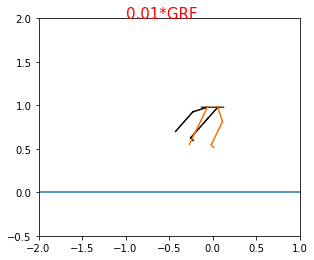

In [21]:
hide_sloution('Plot Solution')

#animate it
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as ani
from IPython.display import HTML
%matplotlib inline

fig1, ax1 = plt.subplots(1,1) #create axes
ax1.set_aspect('equal')

# arrays to store values
N_time = []

def plot_robot(i,m,ax): #update function for animation
    ax.clear()
    ax.set_xlim([-2,x_high_lim])
    ax.set_ylim([y_low_lim,y_high_lim])
    N_time.append(i)
     
    plot_body = {}
    plot_boom = {}
    plot_boom_COM = {}
    plot_UR = {}
    plot_LR = {}
    plot_UL = {}
    plot_LL = {}
    plot_foot = {}
    abs_angles = {}
        
    # plot body
    plot_body.update({('x_back'):m.q[i,'x_body'].value - 0.5*m.lengths['body']*cos(m.q[n,'theta_body'].value)})
    plot_body.update({('y_back'):m.q[i,'y_body'].value - m.y_bodyOffset.value - 0.5*m.lengths['body']*sin(m.q[n,'theta_body'].value)})
    plot_body.update({('x_front'):m.q[i,'x_body'].value + 0.5*m.lengths['body']*cos(m.q[n,'theta_body'].value)})
    plot_body.update({('y_front'):m.q[i,'y_body'].value - m.y_bodyOffset.value + 0.5*m.lengths['body']*sin(m.q[n,'theta_body'].value)})  
    ax.plot([plot_body['x_back'],plot_body['x_front']],[plot_body['y_back'],plot_body['y_front']],color='xkcd:brown')
    
#     # plot boom
#     plot_boom.update({('x_back'): 0.0})
#     plot_boom.update({('y_back'): m.y_bodyOffset.value})
#     plot_boom.update({('x_front'):m.q[i,'x_body'].value })
#     plot_boom.update({('y_front'):m.q[i,'y_body'].value })  
#     ax.plot([plot_boom['x_back'],plot_boom['x_front']],[plot_boom['y_back'],plot_boom['y_front']],color='xkcd:black')

#     # plot boom COM
#     plot_boom_COM.update({('x'): (m.cg.value/m.lx_boom.value)*m.q[i,'x_body'].value})
#     plot_boom_COM.update({('y'): (m.cg.value/m.ly_boom.value)*m.q[i,'y_body'].value})
#     ax.plot([plot_boom_COM['x']],[plot_boom_COM['y']],color='xkcd:purple',marker="o")

    for leg in legs:
        if leg == 'A':
            link_colour = ['black','red']
        else:
            link_colour = ['orange','purple']
        
        
        #plot upper right
        plot_UR.update({('top','X',leg): m.q[i,'x_body'].value + m.BLD.value*cos(m.q[n,'theta_body'].value)})
        plot_UR.update({('top','Y',leg): m.q[i,'y_body'].value - m.y_bodyOffset.value + m.BLD.value*sin(m.q[n,'theta_body'].value)})
        plot_UR.update({('bot','X',leg): plot_UR['top','X',leg] - m.lengths['UR'+leg]*cos(m.q[n,'theta_UR'+leg].value)})
        plot_UR.update({('bot','Y',leg): plot_UR['top','Y',leg] - m.lengths['UR'+leg]*sin(m.q[n,'theta_UR'+leg].value)})
        ax.plot([plot_UR['top','X',leg],plot_UR['bot','X',leg]],[plot_UR['top','Y',leg],plot_UR['bot','Y',leg]],color='xkcd:{0}'.format(link_colour[0]))
        
        #plot lower right
        plot_LR.update({('top','X',leg): plot_UR['bot','X',leg]})
        plot_LR.update({('top','Y',leg): plot_UR['bot','Y',leg]})
        plot_LR.update({('bot','X',leg): plot_UR['bot','X',leg] - m.lengths['LR'+leg]*cos(m.q[n,'theta_LR'+leg].value)})
        plot_LR.update({('bot','Y',leg): plot_UR['bot','Y',leg] - m.lengths['LR'+leg]*sin(m.q[n,'theta_LR'+leg].value)})
        ax.plot([plot_LR['top','X',leg],plot_LR['bot','X',leg]],[plot_LR['top','Y',leg],plot_LR['bot','Y',leg]],color='xkcd:{0}'.format(link_colour[0]))
        
        #plot foot
        plot_foot.update({('top','X',leg): plot_LR['bot','X',leg]})
        plot_foot.update({('top','Y',leg): plot_LR['bot','Y',leg]})
        plot_foot.update({('bot','X',leg): plot_LR['bot','X',leg] + m.foot_length.value*cos(m.foot_angle.value - (np.pi)/2)})
        plot_foot.update({('bot','Y',leg): plot_LR['bot','Y',leg] - m.foot_length.value*sin(m.foot_angle.value - (np.pi)/2)})
        ax.plot([plot_foot['top','X',leg],plot_foot['bot','X',leg]],[plot_foot['top','Y',leg],plot_foot['bot','Y',leg]],color='xkcd:{0}'.format(link_colour[0]))

        #plot upper left
        plot_UL.update({('top','X',leg): m.q[i,'x_body'].value - m.BLD.value*cos(m.q[n,'theta_body'].value)})
        plot_UL.update({('top','Y',leg): m.q[i,'y_body'].value - m.y_bodyOffset.value - m.BLD.value*sin(m.q[n,'theta_body'].value)})
        plot_UL.update({('bot','X',leg): plot_UL['top','X',leg] - m.lengths['UL'+leg]*cos(m.q[n,'theta_UL'+leg].value)})
        plot_UL.update({('bot','Y',leg): plot_UL['top','Y',leg]- m.lengths['UL'+leg]*sin(m.q[n,'theta_UL'+leg].value)})
        ax.plot([plot_UL['top','X',leg],plot_UL['bot','X',leg]],[plot_UL['top','Y',leg],plot_UL['bot','Y',leg]],color='xkcd:{0}'.format(link_colour[0]))

        #plot lower left
        plot_LL.update({('top','X',leg): plot_UL['bot','X',leg]})
        plot_LL.update({('top','Y',leg): plot_UL['bot','Y',leg]})
        plot_LL.update({('bot','X',leg): plot_UL['bot','X',leg] - m.lengths['LL'+leg]*cos(m.q[n,'theta_LR'+leg].value)})
        plot_LL.update({('bot','Y',leg): plot_UL['bot','Y',leg] - m.lengths['LL'+leg]*sin(m.q[n,'theta_LR'+leg].value)})
        ax.plot([plot_LL['top','X',leg],plot_LL['bot','X',leg]],[plot_LL['top','Y',leg],plot_LL['bot','Y',leg]],color='xkcd:{0}'.format(link_colour[0]))     
    
    
    if m.GRF_y[i,'A'].value > 0.0:
        ax.arrow(plot_LL['bot','X','A'], plot_LL['bot','Y','A'], 0, 0.01*m.GRF_y[i,'A'].value,color='xkcd:{0}'.format('red'),head_width = 0.1)
        
    if m.GRF_y[i,'B'].value > 0.0:
        ax.arrow(plot_LR['bot','X','B'], plot_LR['bot','Y','B'], 0, 0.01*m.GRF_y[i,'B'].value,color='xkcd:{0}'.format('red'),head_width = 0.1)
    
#     if m.GRF_x[i,'-ve','B'].value > 0.0:
#         #print('GRF_footL = ',m.GRF_y[i,'footL'].value)
#         ax.arrow(plot_LR['bot','X','B'], plot_LR['bot','Y','B'], 0, 0.01*m.GRF_x[i,'-ve','B'].value,color='xkcd:{0}'.format('blue'),head_width = 0.1)
    
    
    #ax.legend(["GRF*0.01"], frameon=True)
    ax.text(x_low_lim, y_high_lim, '0.01*GRF', color = 'red',fontsize = 15)
    
    ax.plot([-10,10],[0,0]) # plot the ground
    
    
update = lambda i: plot_robot(i,m,ax1) # lambdify update function

animate = ani.FuncAnimation(fig1,update,range(1,N+1),interval = 100,repeat=True)

HTML(animate.to_html5_video()) #you need to convert the animation to HTML5 to embed it in the notebook


In [ ]:
# fileName = test+'_'+str(mu_value)+'_'+str(N)
# f = r"{0}_biped.mp4".format(fileName) 
# writervideo = ani.FFMpegWriter(fps=20) 
# animate.save(f, writer=writervideo) 

In [ ]:
x = np.arange(1,N+1,1)
LeftA = []
RightA = []
LeftB = []
RightB = []

for n in range(1,N+1):
    LeftA.append(m.tau_torque[n,'left','A'].value)
    RightA.append(m.tau_torque[n,'right','A'].value)
    LeftB.append(m.tau_torque[n,'left','B'].value)
    RightB.append(m.tau_torque[n,'right','B'].value)
    
line1 = plt.plot(x,LeftA,label = 'Torque A Left')
line2 = plt.plot(x,LeftB,label = 'Torque A Right')
line3 = plt.plot(x,RightA,label = 'Torque B Left')
line4 = plt.plot(x,RightB,label = 'Torque B Right')
plt.legend()

In [ ]:
x = np.arange(1,N+1,1)
GRF_yA = []
GRF_yB = []


for n in range(1,N+1):
    GRF_yA.append(m.GRF_y[n,'A'].value)
    GRF_yB.append(m.GRF_y[n,'B'].value)
    
line1 = plt.plot(x,GRF_yA,label = 'GRF Y A')
line2 = plt.plot(x,GRF_yB,label = 'GRF Y B')

plt.legend()

In [ ]:
x = np.arange(1,N+1,1)
GRF_xA = []
GRF_xB = []


for n in range(1,N+1):
    GRF_xA.append(m.GRF_x[n,'+ve','A'].value - m.GRF_x[n,'-ve','A'].value)
    GRF_xB.append(m.GRF_x[n,'+ve','B'].value - m.GRF_x[n,'-ve','B'].value)
    
line1 = plt.plot(x,GRF_xA,label = 'GRF X A')
line2 = plt.plot(x,GRF_xB,label = 'GRF X B')

plt.legend()

In [ ]:
x = np.arange(1,N+1,1)
LeftA = []
RightA = []
LeftB = []
RightB = []

for n in range(1,N+1):
    LeftA.append(m.knee_angle[n,'left','A'].value*180/np.pi)
    RightA.append(m.knee_angle[n,'right','A'].value*180/np.pi)
    LeftB.append(m.knee_angle[n,'left','B'].value*180/np.pi)
    RightB.append(m.knee_angle[n,'right','B'].value*180/np.pi)
    
line1 = plt.plot(x,LeftA,label = 'A Left')
line2 = plt.plot(x,LeftB,label = 'A Right')
line3 = plt.plot(x,RightA,label = 'B Left')
line4 = plt.plot(x,RightB,label = 'B Right')
plt.legend()

In [ ]:
bGRFy = []
bFootPos = []
aGRFy = []
aFootPos = []
footScale = 1

for n in range(1,N+1):
    bGRFy.append(m.GRF_y[n,'B'].value)
    bFootPos.append(m.foot_position[n,'Y','B'].value*footScale)
    aGRFy.append(m.GRF_y[n,'A'].value)
    aFootPos.append(m.foot_position[n,'Y','A'].value*footScale)

# bGRFyline = plt.plot(x,bGRFy,label = 'B GRFy')
bFootline = plt.plot(x,bFootPos,label = 'B Foot Pos (y)')
# aGRFyline = plt.plot(x,aGRFy,label = 'A GRFy')
aFootline = plt.plot(x,aFootPos,label = 'A Foot Pos (y)')
plt.legend()

In [ ]:
bFootVel = []
aFootVel = []

for n in range(1,N+1):
    bFootVel.append( m.foot_velocity[n,'X','+ve','B'].value-m.foot_velocity[n,'X','-ve','B'].value)
    aFootVel.append(m.foot_velocity[n,'X','+ve','A'].value-m.foot_velocity[n,'X','-ve','A'].value)

# bGRFyline = plt.plot(x,bGRFy,label = 'B GRFy')
bFootline = plt.plot(x,bFootVel,label = 'B Foot Vel (x)')
# aGRFyline = plt.plot(x,aGRFy,label = 'A GRFy')
aFootline = plt.plot(x,aFootVel,label = 'A Foot Vel (x)')
plt.legend()

In [ ]:
saveFile = False
loops = 5

if saveFile == True:
    fileName = test+'_'+str(N)
    f = r"{0}_biped.mp4".format(fileName) 
    writervideo = ani.FFMpegWriter(fps=20) 
    animate.save(f, writer=writervideo) 

    nodes = []

    xbody = []
    ybody = []
    thULA = []
    thURA = []
    thLLA = []
    thLRA = []
    thULB = []
    thURB = []
    thLLB = []
    thLRB = []



    dxbody = []
    dybody = []
    dthULA = []
    dthURA = []
    dthLLA = []
    dthLRA = []
    dthULB = []
    dthURB = []
    dthLLB = []
    dthLRB = []

    ddxbody = []
    ddybody = []
    ddthULA = []
    ddthURA = []
    ddthLLA = []
    ddthLRA = []
    ddthULB = []
    ddthURB = []
    ddthLLB = []
    ddthLRB = []

    Torque_leftA = []
    Torque_rightA = []
    Torque_leftB = []
    Torque_rightB = []

    GRF_y_A = []
    GRF_y_B = []
    foot_position_Y_A = []
    foot_position_Y_B = []

    angular_speed_leftA = []
    angular_speed_rightA = []
    angular_speed_leftB = []
    angular_speed_rightB = []



    for n in range(1,N+1):

        xbody.append(m.q[n,'x_body'].value)
        ybody.append(m.q[n,'y_body'].value)
        thULA.append(m.q[n,'theta_ULA'].value) 
        thURA.append(m.q[n,'theta_URA'].value) 
        thLLA.append(m.q[n,'theta_LLA'].value) 
        thLRA.append(m.q[n,'theta_LRA'].value) 
        thULB.append(m.q[n,'theta_ULB'].value) 
        thURB.append(m.q[n,'theta_URB'].value) 
        thLLB.append(m.q[n,'theta_LLB'].value) 
        thLRB.append(m.q[n,'theta_LRB'].value) 

        dxbody.append(m.dq[n,'x_body'].value)
        dybody.append(m.dq[n,'y_body'].value)
        dthULA.append(m.dq[n,'theta_ULA'].value) 
        dthURA.append(m.dq[n,'theta_URA'].value) 
        dthLLA.append(m.dq[n,'theta_LLA'].value) 
        dthLRA.append(m.dq[n,'theta_LRA'].value) 
        dthULB.append(m.dq[n,'theta_ULB'].value) 
        dthURB.append(m.dq[n,'theta_URB'].value) 
        dthLLB.append(m.dq[n,'theta_LLB'].value) 
        dthLRB.append(m.dq[n,'theta_LRB'].value) 

        ddxbody.append(m.ddq[n,'x_body'].value)
        ddybody.append(m.ddq[n,'y_body'].value)
        ddthULA.append(m.ddq[n,'theta_ULA'].value) 
        ddthURA.append(m.ddq[n,'theta_URA'].value) 
        ddthLLA.append(m.ddq[n,'theta_LLA'].value) 
        ddthLRA.append(m.ddq[n,'theta_LRA'].value) 
        ddthULB.append(m.ddq[n,'theta_ULB'].value) 
        ddthURB.append(m.ddq[n,'theta_URB'].value) 
        ddthLLB.append(m.ddq[n,'theta_LLB'].value) 
        ddthLRB.append(m.ddq[n,'theta_LRB'].value) 

        Torque_leftA.append(m.tau_torque[n,'left','A'].value)
        Torque_rightA.append(m.tau_torque[n,'right','A'].value)
        Torque_leftB.append(m.tau_torque[n,'left','B'].value)
        Torque_rightB.append(m.tau_torque[n,'right','B'].value)

        GRF_y_A.append(m.GRF_y[n,'A'].value)
        GRF_y_B.append(m.GRF_y[n,'B'].value)

        foot_position_Y_A.append(m.foot_position[n,'Y','A'].value)
        foot_position_Y_B.append(m.foot_position[n,'Y','B'].value)

        angular_speed_leftA.append(m.tau_velocity[n,'left','A'].value) 
        angular_speed_rightA.append(m.tau_velocity[n,'right','A'].value)
        angular_speed_leftB.append(m.tau_velocity[n,'left','B'].value)
        angular_speed_rightB.append(m.tau_velocity[n,'right','B'].value)

        nodes.append(n)

        pass



    ''' Store first values in csv file '''
    import csv
    # csv_file_name = str(int(V_avg))+'_u{0}'.format(mu_value)
    csv_file_name = "Test_{0}_N{1}".format(test,N)

    heading0 = ['node']
    heading1 = ['x_body','y_body','theta_ULA','theta_URA','theta_LLA','theta_LRA','theta_ULB','theta_URB','theta_LLB','theta_LRB']
    heading2 = ['dx_body','dy_body','dtheta_ULA','dtheta_URA','dtheta_LLA','dtheta_LRA','dtheta_ULB','dtheta_URB','dtheta_LLB','dtheta_LRB']
    heading3 = ['ddx_body','ddy_body','ddtheta_ULA','ddtheta_URA','ddtheta_LLA','ddtheta_LRA','ddtheta_ULB','ddtheta_URB','ddtheta_LLB','ddtheta_LRB']
    heading4 = ['Tau_leftA','Tau_rightA','Tau_leftB','Tau_rightB', 'GRF_yA','GRF_yB']
    heading5 = ['foot_position_Y_A','foot_position_Y_B']
    heading = heading0 + heading1 + heading2 + heading3 + heading4 + heading5

    with open(csv_file_name+'.csv', 'w') as f:
        writer = csv.writer(f)

        writer.writerow(heading)
        
        for repeat in range(0,loops): 
            print('loop = ',repeat)
            for n in range(2*N*repeat,N*(2*repeat+1)):
                node = [n+1]
                n = n+1-repeat*N*2-1
                # 0 - 50 cycle
                data1 = [xbody[n],ybody[n],thULA[n],thURA[n],thLLA[n],thLRA[n],thULB[n],thURB[n],thLLB[n],thLRB[n]]
                data2 = [dxbody[n],dybody[n],dthULA[n],dthURA[n],dthLLA[n],dthLRA[n],dthULB[n],dthURB[n],dthLLB[n],dthLRB[n]]
                data3 = [ddxbody[n],ddybody[n],ddthULA[n],ddthURA[n],ddthLLA[n],ddthLRA[n],ddthULB[n],ddthURB[n],ddthLLB[n],ddthLRB[n]]
                data4 = [Torque_leftA[n],Torque_rightA[n],Torque_leftB[n],Torque_rightB[n],GRF_y_A[n],GRF_y_B[n]]
                data5 = [foot_position_Y_A[n],foot_position_Y_B[n]]
                data = node + data1 + data2 + data3 + data4 + data5
                writer.writerow(data)

            for n in range(N*(2*repeat+1),2*N*(repeat+1)):
                node = [n+1]
                n = n+1-repeat*N*2-N-1
                # 50 - 100 cycle
                data1 = [xbody[n],ybody[n],thULB[n],thURB[n],thLLB[n],thLRB[n],thULA[n],thURA[n],thLLA[n],thLRA[n]]
                data2 = [dxbody[n],dybody[n],dthULB[n],dthURB[n],dthLLB[n],dthLRB[n],dthULA[n],dthURA[n],dthLLA[n],dthLRA[n]]
                data3 = [ddxbody[n],ddybody[n],ddthULB[n],ddthURB[n],ddthLLB[n],ddthLRB[n],ddthULA[n],ddthURA[n],ddthLLA[n],ddthLRA[n]]
                data4 = [Torque_leftB[n],Torque_rightB[n],Torque_leftA[n],Torque_rightA[n],GRF_y_B[n],GRF_y_A[n]]
                data5 = [foot_position_Y_B[n],foot_position_Y_A[n]]
                data = node + data1 + data2 + data3 + data4 + data5
                writer.writerow(data)
                
                
    # csv_file_name = str(int(V_avg))+'_u{0}'.format(mu_value)
    csv_file_name = "SS_N{0}".format(N)

    heading0 = ['node']
    heading1 = ['thULA','thURA','thULB','thURB']
    heading2 = ['dthULA','dthURA','dthULB','dthURB']
    heading3 = ['tLeftA','tRightA','tLeftB','tRightB']
    heading = heading0 + heading1 + heading2 + heading3

    with open(csv_file_name+'.csv', 'w') as f:
        writer = csv.writer(f)
        writer.writerow(heading)
        
        for repeat in range(0,loops): 
            for n in range(2*N*repeat,N*(2*repeat+1)):
                node = [n+1]
                n = n+1-repeat*N*2-1
                # 0 - 50 cycle
                data1 = [thULA[n],thURA[n],thULB[n],thURB[n]]
                data2 = [dthULA[n],dthURA[n],dthULB[n],dthURB[n]]
                data3 = [Torque_leftA[n],Torque_rightA[n],Torque_leftB[n],Torque_rightB[n]]
                data = node + data1 + data2 + data3
                writer.writerow(data)

            for n in range(N*(2*repeat+1),2*N*(repeat+1)):
                node = [n+1]
                n = n+1-repeat*N*2-N-1
                # 50 - 100 cycle
                data1 = [thULB[n],thURB[n],thULA[n],thURA[n]]
                data2 = [dthULB[n],dthURB[n],dthULA[n],dthURA[n]]
                data3 = [Torque_leftB[n],Torque_rightB[n],Torque_leftA[n],Torque_rightA[n]]
                data = node + data1 + data2 + data3
                writer.writerow(data)
                
    with open(csv_file_name+'_details'+'.csv', 'w') as f:
        writer = csv.writer(f)
        writer.writerow(['Test','N','TT','V_avg','loops','cost','mu'])
        writer.writerow(['test',N,TT,V_avg,loops,cost_function_str,mu_value])
                
            
    
    plt.figure()
    plt.plot(angular_speed_leftA,Torque_leftA)
    plt.plot(angular_speed_rightA,Torque_rightA)
    plt.plot(angular_speed_leftB,Torque_leftB)
    plt.plot(angular_speed_rightB,Torque_rightB)

    plt.grid()
    plt.plot(x_p,rated_torque_p,color = 'green',linestyle = '--')
    plt.plot(x_n,rated_torque_n,color = 'green',linestyle = '--')

    plt.plot(x_p, y_p,'b')
    plt.plot(x_n, stall_torque_p,'b')

    plt.fill_between(x_p, y_p, alpha=0.4, color = 'cyan')
    plt.fill_between(x_n, stall_torque_p, alpha=0.4,color = 'cyan')

    plt.plot(x_n, y_n,'r')
    plt.plot(x_p, stall_torque_n,'r')

    plt.fill_between(x_n, y_n, alpha=0.4,color = 'pink')
    plt.fill_between(x_p, stall_torque_n, alpha=0.4,color = 'pink')

    plt.axis((-30,30,-80,80))
    plt.title('New Torque Speed Curve')
    plt.xlabel('Speed (rad/s)')
    plt.ylabel('Torque (Nm)')
    plt.legend(["Tw_leftA", "Tw_rightA","Tw_leftB", "Tw_rightB","rated_torque"], loc=0, frameon=True)
else:
    pass

In [ ]:
ybody

In [ ]:
m.dq[N,'theta_LRB'].value

In [ ]:
save2 = False
if save2 == True:
    data =  {'ybod' : m.q[1,'y_body'].value,
             'dybod' : m.dq[1,'y_body'].value,
        'dxbod' : m.dq[1,'x_body'].value,
             
        'thULA' : m.q[1,'theta_ULA'].value,
        'thLLA' : m.q[1,'theta_LLA'].value,
        'thURA' : m.q[1,'theta_URA'].value,
        'thLRA' : m.q[1,'theta_LRA'].value,

        'thULB' : m.q[1,'theta_ULB'].value,
        'thLLB' : m.q[1,'theta_LLB'].value,
        'thURB' : m.q[1,'theta_URB'].value,
        'thLRB' : m.q[1,'theta_LRB'].value,
             
             
        'dthULA' : m.dq[1,'theta_ULA'].value,
        'dthLLA' : m.dq[1,'theta_LLA'].value,
        'dthURA' : m.dq[1,'theta_URA'].value,
        'dthLRA' : m.dq[1,'theta_LRA'].value,

        'dthULB' : m.dq[1,'theta_ULB'].value,
        'dthLLB' : m.dq[1,'theta_LLB'].value,
        'dthURB' : m.dq[1,'theta_URB'].value,
        'dthLRB' : m.dq[1,'theta_LRB'].value}
    with open('periodic_walk_N1_data_v10.pkl', 'wb') as f: 
        pickle.dump(data, f)



In [ ]:
save2 = False
if save2 == True:
    data =  {'ybod' : m.q[N,'y_body'].value,
             'dybod' : m.dq[N,'y_body'].value,
        'dxbod' : m.dq[N,'x_body'].value,
             
        'thULA' : m.q[N,'theta_ULA'].value,
        'thLLA' : m.q[N,'theta_LLA'].value,
        'thURA' : m.q[N,'theta_URA'].value,
        'thLRA' : m.q[N,'theta_LRA'].value,

        'thULB' : m.q[N,'theta_ULB'].value,
        'thLLB' : m.q[N,'theta_LLB'].value,
        'thURB' : m.q[N,'theta_URB'].value,
        'thLRB' : m.q[N,'theta_LRB'].value,
             
             
        'dthULA' : m.dq[N,'theta_ULA'].value,
        'dthLLA' : m.dq[N,'theta_LLA'].value,
        'dthURA' : m.dq[N,'theta_URA'].value,
        'dthLRA' : m.dq[N,'theta_LRA'].value,

        'dthULB' : m.dq[N,'theta_ULB'].value,
        'dthLLB' : m.dq[N,'theta_LLB'].value,
        'dthURB' : m.dq[N,'theta_URB'].value,
        'dthLRB' : m.dq[N,'theta_LRB'].value}
    with open('periodic_walk_finalN_data_v10.pkl', 'wb') as f: 
        pickle.dump(data, f)